## Load Libraries



In [2]:
using ADCME
using SparseArrays
# using ADCMEKit

using DelimitedFiles

using Dates
using Plots


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [3]:
1800 /180

10.0

## Discretization Options


In [4]:
exp_name = string("EXP_" , Dates.format(now(), "yyyy_mm_dd_HHMMSS"),'_')

###################### Inputs ######################

Lx = 1000
Ly = 1000

T_h = 18000

N_x = 21
N_y = 21

N_steps = 10

N_k = 64

#################### calculations ####################

Ne = N_x * N_y

T = T_h 
dt = T / N_steps

dx = Lx / (N_x-1)
dy = Ly / (N_y-1)

x = LinRange(0,1,N_x)
y = LinRange(0,1,N_y);

## Fine scale Inputs

N_steps_fine = 10
N_k_fine = 100
N_y_fine = 1



files_x = [string("./data/exitq_x_",string(ii),".txt") for ii =1:9]

y_x_list = [readdlm(files_x[ii], ' ', Float64) for ii =1:9];

files_y = [string("./data/exitq_y_",string(ii),".txt") for ii =1:9]

y_y_list = [readdlm(files_y[ii], ' ', Float64) for ii =1:9];

momment2 = maximum([maximum(std(y_x_list)),maximum(std(y_y_list))])

y_x_list = [y_x_list[ii][:,1:180:1800] for ii =1:9];
y_y_list = [y_y_list[ii][:,1:180:1800] for ii =1:9];


## Building matrices for applying BC


In [5]:
ii_l = [i for i in 1:N_x:Ne]
jj_l = [1 for i in 1:N_x:Ne]
vv_l = [1. for i in 1:N_x:Ne]
# B
A_l_m = SparseTensor(ii_l, jj_l, vv_l, Ne, 1) 

ii_r = [i for i in N_x:N_x:Ne]
jj_r = [1 for i in 1:N_x:Ne]
vv_r = [1. for i in 1:N_x:Ne]
A_r_m = SparseTensor(ii_r, jj_r, vv_r, Ne, 1) 


A_m = 1-Array(A_l_m)-Array(A_r_m)



Vector_1 = Array(float([i%N_x!=0 && i%N_x!=N_x-1   for i in 1:Ne-1]))
Vector_N_y = Array(float([i%N_x!=0 && i%N_x!=1   for i in 1:Ne-N_x]))

Vector_0_x = [Vector_1[end:-1:1];0]+[0;Vector_1]
Vector_0_y = [Vector_N_y;zeros(N_x)] + [zeros(N_x);Vector_N_y]
;


### Multi point flux aux matrix


In [6]:
list_m2_x =Int64[]
list_m2_y = Int64[]
list_m2_v = Int64[]

list_m3_x =Int64[]
list_m3_y = Int64[]

list_m4_x =Int64[]
list_m4_y = Int64[]

list_m5_x =Int64[]
list_m5_y = Int64[]
 
for jj in 0:N_y-1
    for ii in 0:N_x-1
        
        
        
        if ii !=0 && ii !=N_x-1
            
            if ii+1 < N_x
                append!(list_m2_x,Int(jj*N_x+ii+1))
                append!(list_m2_y,(jj)*N_x+(ii+1)+1)
                append!(list_m2_v,1)

            end
            
            if ii >0
                append!(list_m2_x,jj*N_x+ii+1)
                append!(list_m2_y,(jj)*N_x+(ii-1)+1)
            end
            
            
            if jj+1 < N_y && ii+1 < N_x
                append!(list_m3_x,jj*N_x+ii+1)
                append!(list_m3_y,(jj+1)*N_x+(ii+1)+1)
            end
            
            if jj > 0 && ii > 0
                append!(list_m3_x,jj*N_x+ii+1)
                append!(list_m3_y,(jj-1)*N_x+(ii-1)+1)
            end
            
            
            if jj+1 < N_y
                append!(list_m4_x,jj*N_x+ii+1)
                append!(list_m4_y,(jj+1)*N_x+ii+1)
            end
            
            if jj >0
                append!(list_m4_x,jj*N_x+ii+1)
                append!(list_m4_y,(jj-1)*N_x+ii+1)
            end
            
            if jj+1 < N_y && ii > 0
                append!(list_m5_x,jj*N_x+ii+1)
                append!(list_m5_y,(jj+1)*N_x+(ii-1)+1)
            end
            
            if jj > 0 && ii+1 < N_x
                append!(list_m5_x,jj*N_x+ii+1)
                append!(list_m5_y,(jj-1)*N_x+(ii+1)+1)
            end

        end
    end
end

m2_m = SparseTensor(list_m2_x,list_m2_y,ones(size(list_m2_y)),Ne,Ne)
m3_m = SparseTensor(list_m3_x,list_m3_y,ones(size(list_m3_y)),Ne,Ne)
m4_m = SparseTensor(list_m4_x,list_m4_y,ones(size(list_m4_y)),Ne,Ne)
m5_m = SparseTensor(list_m5_x,list_m5_y,ones(size(list_m5_y)),Ne,Ne);


m2_m_1 = SparseTensor(list_m2_x,list_m2_x,ones(size(list_m2_x)),Ne,Ne)
m3_m_1 = SparseTensor(list_m3_x,list_m3_x,ones(size(list_m3_x)),Ne,Ne)
m4_m_1 = SparseTensor(list_m4_x,list_m4_x,ones(size(list_m4_x)),Ne,Ne)
m5_m_1 = SparseTensor(list_m5_x,list_m5_x,ones(size(list_m5_x)),Ne,Ne);

## Functions for applying BC & IC, building matrix A


In [7]:
function left_BC(t)
    
    t_norm = (t/T-0.5)*180
    
    tanh(-t_norm/500)
    
    end;

function BC(t)

    BC_right_ = zeros(N_y)
    
    BC_left_ = (map(tanh,LinRange(-31.5,31.5,N_y)/50) * left_BC(t))*5  .+ 1

    
    BC_left = SparseTensor(ii_l, jj_l, BC_left_, Ne, 1) 
    BC_right = SparseTensor(ii_r, jj_r, BC_right_, Ne, 1)
    
    
#     constant(ones(N_y) ) + constant(1e-4 * t )
return BC_left, BC_right, BC_left_, BC_right_
    
end


function IC()
    
    _,_ , BC_left, Bc_right = BC(0)
    
    h_0 = reshape((reshape(BC_left,(N_y,1)) .- reshape(BC_left,(N_y,1)) * reshape(constant(x),(1,N_x))),(1,Ne)).* ones(N_k,1)
return h_0
end

;

## Basic time-loop definition


In [8]:
N_k_dis = placeholder(N_k,dtype=Int32)


N_x_ = constant(N_x,dtype=Int32)
N_y_ = constant(N_y,dtype=Int32)
Ne_ = constant(Ne,dtype=Int32)

N_points = 9

# function get_grad(h_,loc_x_p,loc_x_m,loc_y_p,loc_y_m)
    
  
#     DL = sqrt(((loc_x_p-loc_x_m)*dx)^2+((loc_y_p-loc_y_m)*dy)^2)
#     (tf.slice(h_,constant([0,(loc_y_p-1)*N_x+loc_x_p-1], dtype=Int32),[-1,1])-tf.slice(h_,constant([0,(loc_y_m-1)*N_x + (loc_x_m-1)], dtype=Int32),[-1,1]))/DL     
    
# end


loc_x_list = [6,11,16, 6,11,16, 6,11,16]

loc_y_list = [6, 6, 6,11,11,11,16,16,16];


# loc_x_p_list_x = loc_x_list
# loc_x_m_list_x = loc_x_list
# loc_y_p_list_x = loc_y_list
# loc_y_m_list_x = loc_y_list;


# loc_x_p_list_y = loc_x_list
# loc_x_m_list_y = loc_x_list
# loc_y_p_list_y = loc_y_list
# loc_y_m_list_y = loc_y_list;


In [9]:
function P(h_,i,j)
    tf.slice(h_,constant([0,(j-1)*N_x+i-1], dtype=Int32),[-1,1])
end
    

function get_hor_flux(a,b,c,h_,i,j)
    
    ((a    .- tf.square(c) ./(2*b)) .* (P(h_,i,j)-P(h_,i+1,j)) +
    (c./4 .+ tf.square(c) ./(4*b)) .* (P(h_,i-1,j-1)-P(h_,i+1,j+1)) +
    (c./4 .- tf.square(c) ./(4*b)) .* (P(h_,i-1,j+1)-P(h_,i+1,j-1)) )/dx
end

function get_ver_flux(a,b,c,h_,i,j)
    
    ((b    .- tf.square(c) ./(2*a)) .* (P(h_,i,j)-P(h_,i,j+1)) +
    (c./4 .+ tf.square(c) ./(4*a)) .* (P(h_,i+1,j-1)-P(h_,i-1,j+1)) +
    (c./4 .- tf.square(c) ./(4*a)) .* (P(h_,i-1,j-1)-P(h_,i+1,j+1)) )/dy

end

get_ver_flux (generic function with 1 method)

In [10]:
function advance_time(a,b,c,h_)
      

    h_n = TensorArray(N_k)
    j = constant(1,dtype=Int32)
    
    
    aa = tf.slice(a,[j-1,0],[1,1])[1,1]
    bb = tf.slice(b,[j-1,0],[1,1])[1,1]
    cc = tf.slice(c,[j-1,0],[1,1])[1,1]

    dd = (2 * aa * bb) / (aa+bb) 

    m2 = -aa + cc^2 / dd
    m3 = -cc/2 - cc^2 / (2 * dd)
    m4 = -bb + cc^2 / dd
    m5 = -cc/2 - cc^2 / (2 * dd)

    A = m2 * m2_m + m3 * m3_m + m4 * m4_m + 
    m5 * m5_m + m2 * m2_m_1 + m3 * m3_m_1 +
    m4 * m4_m_1 + m5 * m5_m_1 + spdiag(Ne)


    function condition(j,h_n)
        j <= N_k_dis
    end

    function body(j,h_n)   
#         # build lhs
        aa = tf.slice(a,[j-1,0],[1,1])[1,1]
        bb = tf.slice(b,[j-1,0],[1,1])[1,1]
        cc = tf.slice(c,[j-1,0],[1,1])[1,1]
        
        dd = (2 * aa * bb) / (aa+bb) 
        
        m2 = -aa + cc^2 / dd
        m3 = -cc/2 - cc^2 / (2 * dd)
        m4 = -bb + cc^2 / dd
        m5 = -cc/2 - cc^2 / (2 * dd)
        
    
        A = m2 * m2_m + m3 * m3_m + m4 * m4_m + 
        m5 * m5_m - (m2 * m2_m_1 + m3 * m3_m_1 +
        m4 * m4_m_1 + m5 * m5_m_1 - spdiag(Ne))      
        
        # solve system
        
        h_j = A\h_[j]
        
        # update head
        h_n = write(h_n,j,h_j)

        j+1, h_n
    end

    _, out = while_loop(condition, body, [j, h_n])


    return stack(out)

end


advance_time (generic function with 1 method)

### Time loop change calculation of flux to multipoint

### Initialization of the problem


In [11]:
h_IC = IC()


h_t = TensorArray(N_steps)
h_t = write(h_t, 1,constant(h_IC))

k_x_t_log = Variable(ones(N_k,N_steps)*log(1e-2).+ 0.0.*(0.0 .+ 5e-4 .* (0.5 .- rand(N_k,N_steps))))
k_x_t = tf.exp(k_x_t_log)

k_y_t_log = Variable(ones(N_k,N_steps)*log(1e-2).+ 0.0.*(0.0 .+ 5e-4 .* (0.5 .- rand(N_k,N_steps))))
k_y_t = tf.exp(k_y_t_log)

# make it tanh
k_xy_t_log = Variable(zeros(N_k,N_steps)  .+ 4e-2.*(0.5 .- rand(N_k,N_steps)))
k_xy_t = tf.tanh(k_xy_t_log) .* k_x_t^0.5 .* k_y_t^0.5
# k_xy_t = k_xy_t_log .* k_x_t^0.5 .* k_y_t^0.5

k_x = tf.slice(k_x_t,constant([0,0],dtype=Int32),[-1,1]) 
k_y = tf.slice(k_y_t,constant([0,0],dtype=Int32),[-1,1]) 
k_xy = tf.slice(k_xy_t,constant([0,0],dtype=Int32),[-1,1]) 


    
q_t_x = [TensorArray(N_steps) for ii = 1:N_points]
q_t_y = [TensorArray(N_steps) for ii = 1:N_points];


In [12]:
q_x = [get_hor_flux(k_x,k_y,k_xy,h_IC,loc_x_list[ii],loc_y_list[ii]) for ii in 1:length(loc_x_list)]
q_y = [get_ver_flux(k_x,k_y,k_xy,h_IC,loc_x_list[ii],loc_y_list[ii]) for ii in 1:length(loc_x_list)]

q_t_x = [write(q_t_x[ii],1,q_x[ii]) for ii = 1:N_points];
q_t_y = [write(q_t_y[ii],1,q_y[ii]) for ii = 1:N_points];
    

In [13]:
check_qt = TensorArray(N_steps)

PyObject <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7f8f37786b10>

In [14]:
q_check = get_hor_flux(k_x,k_y,k_xy,h_IC,11,11)/(dx*dy)-get_hor_flux(k_x,k_y,k_xy,h_IC,12,11)/(dx*dy)+
          get_ver_flux(k_x,k_y,k_xy,h_IC,11,11)/(dx*dy)-get_ver_flux(k_x,k_y,k_xy,h_IC,11,12)/(dx*dy)

check_qt = write(check_qt,1,q_check)

PyObject <tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x7f8f1a9a1cd0>

In [15]:
i = constant(2, dtype=Int32)

S = 1e-6

function condition(i, h_t, q_t_x, q_t_y,check_qt)
    i<= N_steps
end

function body(i, h_t, q_t_x, q_t_y, check_qt)
    
    
    
    # calculate time
    t = cast(i-1,Float64)*dt

    # build rhs
    h_rhs = read(h_t, i-1)
    BC_left, BC_right = BC(t)
    h_rhs = h_rhs .* A_m[:,1] + Array(BC_left)[:,1] + Array(BC_right)[:,1]

    #extract permiabillityh
    k_x = tf.slice(k_x_t,[0,i-1],[-1,1]) 
    k_y = tf.slice(k_y_t,[0,i-1],[-1,1])
    k_xy = tf.slice(k_xy_t,[0,i-1],[-1,1])

    # advance time
    h_next = advance_time(k_x/S,k_y/S,k_xy/S,h_rhs)

    # # # update hydraulic head
    h_t = write(h_t, i, h_next)

    q_x = [get_hor_flux(k_x,k_y,k_xy,h_next,loc_x_list[ii],loc_y_list[ii]) for ii in 1:length(loc_x_list)]
    q_y = [get_ver_flux(k_x,k_y,k_xy,h_next,loc_x_list[ii],loc_y_list[ii]) for ii in 1:length(loc_x_list)]
    
    
    q_t_x = [write(q_t_x[ii],i,q_x[ii]) for ii = 1:N_points];
    q_t_y = [write(q_t_y[ii],i,q_y[ii]) for ii = 1:N_points];
    
    
    q_check = get_hor_flux(k_x,k_y,k_xy,h_next,11,11)/(dx*dy)-get_hor_flux(k_x,k_y,k_xy,h_next,12,11)/(dx*dy)+
              get_ver_flux(k_x,k_y,k_xy,h_next,11,11)/(dx*dy)-get_ver_flux(k_x,k_y,k_xy,h_next,11,12)/(dx*dy)

    check_qt = write(check_qt,i,q_check)
        
    i+1, h_t, q_t_x, q_t_y, check_qt
    
end

_, out, outx, outy, outcheck = while_loop(condition, body, [i, h_t,q_t_x, q_t_y, check_qt])

h_t = stack(out)

q_t_x = [stack(outx[i]) for i=1:N_points]
q_t_y = [stack(outy[i]) for i=1:N_points];


### Initiilze Descrite Probabilities


In [16]:
N_k_dis_ = 4

p_pre_soft_max_values = ones(1,N_k) .+ (1e0 .* rand(1,N_k)) ;

for i = 1:N_k_dis_

p_pre_soft_max_values[1,i] +=100
end

p_pre_soft_max = tf.Variable(p_pre_soft_max_values)
p = tf.nn.softmax(p_pre_soft_max,1)


lambda = placeholder(ones(1))

PyObject <tf.Tensor 'PlaceholderWithDefault_2:0' shape=(1,) dtype=float64>

### Loss Function Definition


In [17]:
function loss_function(y_t,q_t)
    
    
    q_t = tf.slice(q_t,constant([0,0,0],dtype=Int32),constant([-1,-1,1],dtype=Int32))

    dw = tf.squared_difference(constant(reshape(y_t,(N_steps,N_k_fine,1))),constant(reshape(q_t,(N_steps,1,N_k))))


    dw_2_sum = tf.reduce_mean(dw) * 1e20


    dw_2_mean = tf.reduce_sum(tf.reduce_mean(dw,axis=0).*p)/N_k_fine
    momment2 = reshape(std(y_t,dims=1),(N_steps,1,1)).^2;


    dw = tf.reduce_sum(dw ./ momment2,axis=0)
#     dw = tf.reduce_sum(dw ,axis=0)


    dw_min = tf.reduce_min(dw,1,keepdims=true)
    dw_m_min = -dw + dw_min



    F = p .* tf.exp(dw_m_min/lambda)

    F = tf.reduce_sum(F,1,keep_dims=true)

    F = tf.log(F)- dw_min/lambda

    loss = - tf.reduce_sum(F)/N_k_fine


    return loss , dw_2_sum
end




loss_function (generic function with 1 method)

In [18]:
loss_x_list = [loss_function(y_x_list[ii],q_t_x[ii]) for ii = 1:N_points]
loss_y_list = [loss_function(y_y_list[ii],q_t_y[ii]) for ii = 1:N_points];

loss_x = loss_x_list[5][1] #+ loss_x_list[4][1] 
loss_y = loss_y_list[5][1] #+ loss_y_list[4][1] 


loss = loss_x + loss_y 
# loss = loss_y

dw_x = loss_x_list[5][2]# + loss_x_list[4][2] 
dw_y = loss_y_list[5][2]# + loss_x_list[4][2] 


dw_2_sum = dw_x + dw_y

PyObject <tf.Tensor 'add_86:0' shape=() dtype=float64>

## Metric for CDF spreading


In [19]:
sort_list = [tf.sort(tf.slice(q_t_x[ii],[0,0,0],[N_steps,N_k_dis,1]),axis=1) for ii=5]

diff_list = [tf.reduce_max(tf.reduce_min((tf.slice(sort_list[ii],[0,1,0],[-1,-1,-1])-(tf.slice(sort_list[ii],[0,0,0],[-1,N_k_dis-1,-1])))./tf.reduce_mean(sort_list[ii],axis=1,keep_dims=true),axis=1)) for ii =1]



diff_eval =  tf.reduce_max(tf.stack(diff_list))


# sort = tf.sort(tf.slice(q_t_x[5],[0,0,0],[N_steps,N_k_dis,1]),axis=1)
# diff = tf.reduce_max(tf.reduce_min((tf.slice(sort,[0,1,0],[-1,-1,-1])-(tf.slice(sort,[0,0,0],[-1,N_k_dis-1,-1])))./tf.reduce_mean(sort,axis=1,keep_dims=true),axis=1))


PyObject <tf.Tensor 'Max_1:0' shape=() dtype=float64>

## Loss function optimization

In [20]:
opt_ADAM = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss* 1e5) 

opt_LFGS = ScipyOptimizerInterface(loss; method="L-BFGS-B", options=Dict("maxiter"=> 400, "ftol"=>1e-10, "gtol"=>1e-8))

opt_ADAM_sum = tf.train.AdamOptimizer(learning_rate=0.001).minimize(dw_2_sum)

opt_LFGS_sum = ScipyOptimizerInterface(dw_2_sum * 1e5; method="L-BFGS-B", options=Dict("maxiter"=> 200, "ftol"=>1e-12, "gtol"=>1e-16))


PyObject <tensorflow.contrib.opt.python.training.external_optimizer.ScipyOptimizerInterface object at 0x7f8e81d4fe90>

In [21]:
# opt_LFGS._packed_var

# opt_LFGS._packed_loss_grad
# opt = tf.train.AdamOptimizer(learning_rate=0.001)
# grads_and_vars = opt.compute_gradients(loss,k_x_t_log)
# opt_check = opt.apply_gradients(grads_and_vars)

# opt = GradientDescentOptimizer(learning_rate=0.1)

# # Compute the gradients for a list of variables.
# grads_and_vars = opt.compute_gradients(loss, <list of variables>)

# # grads_and_vars is a list of tuples (gradient, variable).  Do whatever you
# # need to the 'gradient' part, for example cap them, etc.
# capped_grads_and_vars = [(MyCapper(gv[0]), gv[1]) for gv in grads_and_vars]

# # Ask the optimizer to apply the capped gradients.
# opt.apply_gradients(capped_grads_and_vars)

# run(sess,opt_check,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>4))


## Session Initialization


In [22]:
sess = Session(); init(sess)

2021-01-12 19:07:51.344170: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-01-12 19:07:51.367409: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2021-01-12 19:07:51.368055: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b5dbc249e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-01-12 19:07:51.368068: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-01-12 19:07:51.369634: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-01-12 19:07:51.462131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-12

## Function for storing & updating variables


In [23]:
function update_K_p(check_diff,N_k_dis_)

    
print("function for update K:",check_diff,"\t",N_k_dis_,"\n")
if check_diff > 5e-2 && N_k_dis_ < N_k
        
        
    k_x_t_update = run(sess,k_x_t_log) 
    k_x_t_update[N_k_dis_+1:N_k_dis_*2,:] = k_x_t_update[1:N_k_dis_,:] 
    k_x_t_update = k_x_t_update .+ (0.0 .+ 5e-4 .* (0.5 .- rand(N_k,N_steps)))
    run(sess,tf.assign(k_x_t_log,k_x_t_update));
    
    k_y_t_update = run(sess,k_y_t_log) 
    k_y_t_update[N_k_dis_+1:N_k_dis_*2,:] = k_y_t_update[1:N_k_dis_,:] 
    k_y_t_update = k_y_t_update .+ (0.0 .+ 5e-4.* (0.5 .- rand(N_k,N_steps)))
    run(sess,tf.assign(k_y_t_log,k_y_t_update));   
        
    k_xy_t_update = run(sess,k_xy_t_log) 
    k_xy_t_update[N_k_dis_+1:N_k_dis_*2,:] = k_xy_t_update[1:N_k_dis_,:] 
    k_xy_t_update = k_xy_t_update .+ (0.0 .+ 5e-4 .* (0.5 .- rand(N_k,N_steps)))
    run(sess,tf.assign(k_x_t_log,k_x_t_update));

    p_pre_soft_max_update = run(sess,p_pre_soft_max) 
    p_pre_soft_max_update[:,N_k_dis_+1:N_k_dis_*2] = p_pre_soft_max_update[:,1:N_k_dis_] 
    p_pre_soft_max_update = p_pre_soft_max_update .* (1.0 .+ 5e-3 *  (rand(1,N_k).-0.5))
    run(sess,tf.assign(p_pre_soft_max,p_pre_soft_max_update));
    
    N_k_dis_ *=2
else
    k_x_t_update = run(sess,k_x_t_log) .+ (0.0 .+5e-3 *  (rand(N_k,N_steps).-0.5));
    run(sess,tf.assign(k_x_t_log,k_x_t_update));
        
    k_y_t_update = run(sess,k_y_t_log) .+ (0.0 .+5e-3 *  (rand(N_k,N_steps).-0.5));
    run(sess,tf.assign(k_y_t_log,k_y_t_update));
        
    k_xy_t_update = run(sess,k_xy_t_log) .+ (0.0 .+5e-4 *  (rand(N_k,N_steps).-0.5));
    run(sess,tf.assign(k_xy_t_log,k_xy_t_update));
        
    p_pre_soft_max_update = run(sess,p_pre_soft_max) .* (1 .+5e-3 *  (rand(1,N_k).-0.5));
    run(sess,tf.assign(p_pre_soft_max,p_pre_soft_max_update));
end
    
    
    
return N_k_dis_
end



function plot_cdf()

q_t_ = run(sess,q_t,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))
p_ = run(sess,p,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))


ind  = sortperm(q_t_[time_step,:,1])

plot!(q_t_[time_step,ind,1],cumsum(p_[1,ind]))


    
end

plot_cdf (generic function with 1 method)

In [24]:
N_k_dis_ = 4

T_exp = -10


T_=  10.0 .^ -T_exp

1.0e10

## Initialization with average


In [25]:

ScipyOptimizerMinimize(sess, opt_LFGS_sum,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>16))



In [26]:
check_diff = run(sess,diff_eval,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_))

0.0012278904332035762

## Initialize cdf


In [27]:
# time_step = 5

# ind  = sortperm(y_t_list[5][time_step,:])

# plot(y_t[time_step,ind],LinRange(0,1,N_k_fine))

# plot_cdf()


## Initialize Save txt


In [28]:
k_x_save = run(sess,k_x_t)

k_y_save = run(sess,k_y_t)

p_save = run(sess,p)

q_x_save = run(sess,q_t_x[5])

q_y_save = run(sess,q_t_y[5])


open(string(exp_name,"k_x.txt"), "w") do io
           writedlm(io, k_x_save)
end


open(string(exp_name,"k_y.txt"), "w") do io
           writedlm(io, k_y_save)
end

open(string(exp_name,"p.txt"), "w") do io
           writedlm(io, p_save)
end


open(string(exp_name,"q_x.txt"), "w") do io
           writedlm(io, q_x_save)
end

open(string(exp_name,"q_y.txt"), "w") do io
           writedlm(io, q_y_save)
end


In [29]:
T_exp_final = 0

0

In [30]:
T_exp_final = T_exp+6

-4

In [31]:

while T_exp <= T_exp_final

    T_=  10.0 ^ (-T_exp) 

    diff_,loss_ = run(sess,[diff_eval,loss],feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_))

    print(T_exp,"\t",T_,"\t",diff_,"\t",loss_,"\t","\t",N_k_dis_,"\n")    
    
    check_diff_ = run(sess,diff_eval,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_))  
    N_k_dis_ = update_K_p(check_diff_,N_k_dis_)  
    
    diff_,loss_ = run(sess,[diff_eval,loss],feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_))

    
    print(T_exp,"\t",T_,"\t",diff_,"\t",loss_,"\t","\t",N_k_dis_,"\n") 
    ScipyOptimizerMinimize(sess, opt_LFGS,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_))

    diff_,loss_ = run(sess,[diff_eval,loss],feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_))

    print(T_exp,"\t",T_,"\t",diff_,"\t",loss_,"\t","\t",N_k_dis_,"\n")



    if round(T_exp,digits=2)%1 == 0

        k_x_save = run(sess,k_x_t)

        k_y_save = run(sess,k_y_t)

        p_save = run(sess,p)

        q_x_save = run(sess,q_t_x[5])

        q_y_save = run(sess,q_t_y[5])


            open(string(exp_name,"k_x.txt"), "a") do io
                       writedlm(io, k_x_save)
            end


            open(string(exp_name,"k_y.txt"), "a") do io
                       writedlm(io, k_y_save)
            end

            open(string(exp_name,"p.txt"), "a") do io
                       writedlm(io, p_save)
            end


            open(string(exp_name,"q_x.txt"), "a") do io
                       writedlm(io, q_x_save)
            end

            open(string(exp_name,"q_y.txt"), "a") do io
                       writedlm(io, q_y_save)
            end


        check_diff_ = run(sess,diff_eval,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_))  

#         N_k_dis_ = update_K_p(check_diff_,N_k_dis_)  

          

    end


    T_exp += 0.1
end


-10	1.0e10	0.0012278904332035762	2.4995779161257317e-9		4
function for update K:0.0012278904332035762	4
-10	1.0e10	0.0007342783293975189	2.500053746839446e-9		4
-10	1.0e10	0.0007342783293975189	2.500053746839446e-9		4
-9.9	7.943282347242822e9	0.0007342783293975189	3.147381272995797e-9		4
function for update K:0.0007342783293975189	4
-9.9	7.943282347242822e9	0.001884286194683399	3.147244199750968e-9		4
-9.9	7.943282347242822e9	0.001884286194683399	3.147244199750968e-9		4
-9.8	6.309573444801943e9	0.001884286194683399	3.962145738876757e-9		4
function for update K:0.001884286194683399	4
-9.8	6.309573444801943e9	0.0020642885002024997	3.962202167556645e-9		4
-9.8	6.309573444801943e9	0.0020642885002024997	3.962202167556645e-9		4
-9.700000000000001	5.011872336272736e9	0.0020642885002024997	4.988117000695314e-9		4
function for update K:0.0020642885002024997	4
-9.700000000000001	5.011872336272736e9	0.0019480574075711806	4.988588917166872e-9		4
-9.700000000000001	5.011872336272736e9	0.00194805740

In [110]:
# opt_LFGS_2 = ScipyOptimizerInterface(loss * 1e5; method="L-BFGS-B", options=Dict("maxiter"=> 200, "ftol"=>1e-15, "gtol"=>1e-18))


In [111]:
# ScipyOptimizerMinimize(sess, opt_LFGS_2,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_))


In [112]:
# N_k_dis_ = update_K_p(10,N_k_dis_)

ii = 5

# i_y = (ii-1) ÷ 3 + 1
# i_y = (ii-1) ÷ 3 + 1

# y_y_list[ii]

time_step = 5

5

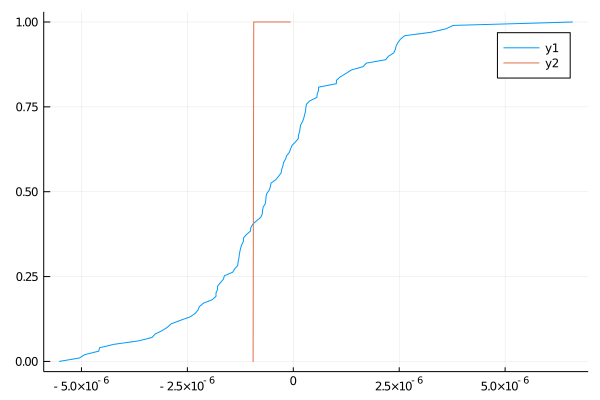

In [113]:


ind  = sortperm(y_y_list[ii][:,time_step])

plot(y_y_list[ii][ind,time_step],LinRange(0,1,N_k_fine))

q_t_ = run(sess,q_t_y[ii],feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))
p_ = run(sess,p,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))


ind  = sortperm(q_t_[time_step,:,1])

# plot!(q_t_[time_step,ind,1],cumsum(p_[1,ind]))
plot!([q_t_[time_step,ind,1];q_t_[time_step,ind[end],1]],[0;cumsum(p_[1,ind])])


# ind  = sortperm(y_y_list[ii][:,time_step])

# plot!(y_y_list[ii][ind,time_step],LinRange(0,1,N_k_fine))


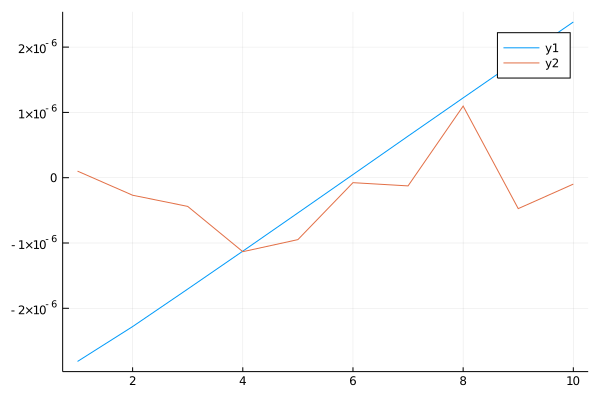

In [114]:
plot(mean(y_y_list[ii],dims=1)[1,:])
plot!(sum(q_t_[:,:,1] .* p_,dims=2))

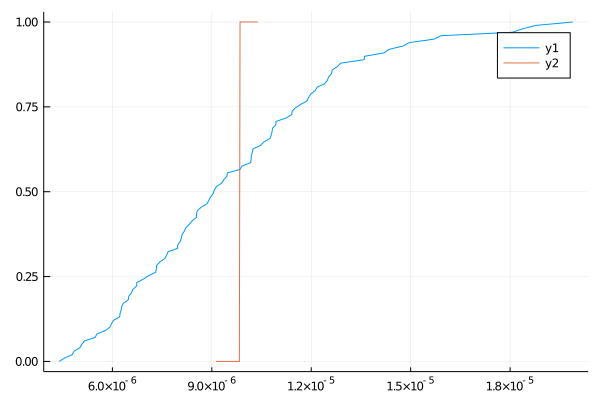

In [115]:


# i_y = (ii-1) ÷ 3 + 1
# i_y = (ii-1) ÷ 3 + 1

# y_y_list[ii]

# time_step = 5

ind  = sortperm(y_x_list[ii][:,time_step])

plot(y_x_list[ii][ind,time_step],LinRange(0,1,N_k_fine))

q_t_ = run(sess,q_t_x[ii],feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))
p_ = run(sess,p,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))


ind  = sortperm(q_t_[time_step,:,1])

# plot!(q_t_[time_step,ind,1],cumsum(p_[1,ind]))
plot!([q_t_[time_step,ind,1];q_t_[time_step,ind[end],1]],[0;cumsum(p_[1,ind])])


# ind  = sortperm(y_y_list[ii][:,time_step])

# plot!(y_y_list[ii][ind,time_step],LinRange(0,1,N_k_fine))


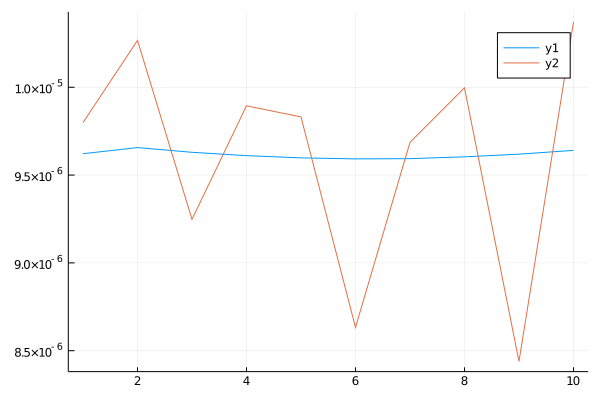

In [116]:
plot(mean(y_x_list[ii],dims=1)[1,:])
plot!(sum(q_t_[:,:,1] .* p_,dims=2))

In [80]:
check_diff_ = run(sess,diff_eval,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>N_k_dis_)) 

0.015796071122980586

In [45]:
run(sess,loss_x,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))

1.215539423140234e11

In [46]:
run(sess,loss_y,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))

1.7579586853385095e11

In [45]:
check = run(sess,k_x_t,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))


64×10 Array{Float64,2}:
 0.0175976   0.00873785  0.00853511  …  0.00917998  0.0139304   0.00795707
 0.00734641  0.0115521   0.011014       0.00704244  0.0110451   0.0137559
 0.00820512  0.00591146  0.00796514     0.00604525  0.0196216   0.00796805
 0.00786103  0.00949342  0.00557904     0.00638253  0.0102941   0.0125132
 0.00822766  0.00128245  0.00553509     0.00754807  0.0128364   0.00684118
 0.0122452   0.00932687  0.00732185  …  0.00716809  0.00902998  0.00849908
 0.0104153   0.010122    0.00974651     0.0112695   0.00639716  0.00705946
 0.0112518   0.00723797  0.00573228     0.00412745  0.0141439   0.00689986
 0.0179302   0.00883348  0.00882129     0.00898989  0.0140631   0.00812677
 0.00710226  0.0116339   0.0105907      0.00711727  0.0113165   0.0132701
 0.00804071  0.00577316  0.00796578  …  0.00606063  0.0191419   0.00757474
 0.00773197  0.00942695  0.00580074     0.00621436  0.0102698   0.0128628
 0.00830504  0.00130512  0.00557109     0.00761741  0.0127594   0.00690124
 ⋮   

In [46]:
check[50,:]

10-element Array{Float64,1}:
 0.009926811959270435
 0.010125774945549941
 0.009812900376303524
 0.009703492240174019
 0.009983717612824013
 0.009674747583100562
 0.010072881169505596
 0.010275190948230687
 0.009848803850838214
 0.010469007391334743

In [47]:
check[5,:]

10-element Array{Float64,1}:
 0.00822766471869104
 0.0012824538879645914
 0.005535087887744081
 0.010815475772204826
 0.007778921580876297
 0.007028380828413854
 0.013277655411184952
 0.007548065867028431
 0.012836448345618957
 0.006841175189286863

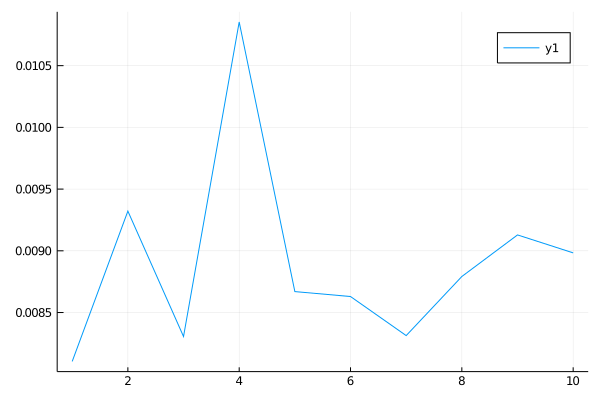

In [40]:
plot(mean(check,dims=1)[1,:])

In [ ]:
plot_check = run(sess,stack(outcheck))

In [ ]:
# using DelimitedFiles

In [ ]:
# writedlm("conservation_check.csv",plot_check,",")

In [ ]:
plot(Array(mean(y_x_list[ii],dims=1))[1,:])
plot!(Array(mean(q_t_[:,:,1],dims=2)))

In [ ]:
q_t_

In [ ]:

q_t_ = run(sess,q_t_y[ii],feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))
p_ = run(sess,p,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))


ind  = sortperm(q_t_[time_step,:,1])

plot!(q_t_[time_step,ind,1],cumsum(p_[1,ind]))


ii = 5
ind  = sortperm(y_x_list[ii][:,time_step])

plot(y_x_list[ii][ind,time_step],LinRange(0,1,N_k_fine))

q_t_ = run(sess,q_t_x[ii],feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))
p_ = run(sess,p,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))


ind  = sortperm(q_t_[time_step,:,1])

plot!(q_t_[time_step,ind,1],cumsum(p_[1,ind]))

ind  = sortperm(y_y_list[ii][:,time_step])

plot(y_y_list[ii][ind,time_step],LinRange(0,1,N_k_fine))

q_t_ = run(sess,q_t_y[ii],feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))
p_ = run(sess,p,feed_dict = Dict(lambda => ones(1)*T_,N_k_dis=>64.0))


ind  = sortperm(q_t_[time_step,:,1])

plot!(q_t_[time_step,ind,1],cumsum(p_[1,ind]))

loss_y_list

run(sess,loss_x_list[5])

run(sess,loss_y_list[5])

run(sess,loss)

q_t_[time_step,ind,1]

plot(transpose(p_save  * k_x_save))


plot(transpose(p_save  * k_y_save))


transpose(p_save  * k_x_save)

check = run(sess,h_t)

reshape(check[1,1,:],(21,21))

# h_t



In [ ]:
check = run(sess,h_t)

In [ ]:
reshape(check[1,:],21,21)[11,11]-reshape(check[1,:],21,21)[11,12]

In [ ]:
tt = 10
reshape(check[tt,10,:],21,21)[11,11]-reshape(check[tt,10,:],21,21)[11,12]

In [ ]:
Array(mean((y_y_list[5][:,:]),dims=1))

In [ ]:
plot(Array(mean((y_y_list[4][:,:]),dims=1))[1,:])

In [ ]:
y_y_list[5]

In [ ]:
plot(run(sess,k_xy_t)[1,:])

In [ ]:
plot(std(y_y_list[5],dims=1)[1,:])

In [ ]:
plot(mean(q_t_[:,:,1],dims=2))
plot!(maximum(q_t_[:,:,1],dims=2))

In [ ]:
plot(mean(y_y_list[5],dims=1)[1,:])

In [ ]:
mean(y_y_list[5],dims=1)[1,:]